October: This notebook extracts the realistic bathymetry of the domain.

In [1]:
import numpy as np
import netCDF4 as nc
import os
import scipy as sc, scipy.io
from pyproj import Proj, transform
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import colormap_ibcao
from scipy.interpolate import griddata
from salishsea_tools import bathy_tools
%matplotlib inline

# 1. Get the coordinates of the mackenzie grid

The coordinates in these files are in geographic projection.

In [2]:
coord_name = 'coords_mack06.nc'
grid_name = 'grid_mack06.nc'

In [3]:
# Post JP matlab script
coord_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid/tests_coordinates/' + coord_name)
lon_g_coord = coord_file['nav_lon']
lat_g_coord = coord_file['nav_lat']

# Produced by SEAgrid
grid_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid/tests_grids/' + grid_name)
lon_g_grid = grid_file['grid_lons']
lat_g_grid = grid_file['grid_lats']

# 2. Get the IBCAO coordinates and bathymetry

The coordinates in this file are in stereographic projection, which is used to mitigate the effects of projection distortion in the Arctic.

In [4]:
# Full dataset
ibcao_file = scipy.io.netcdf_file('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid/IBCAO_V3_500m_RR.grd')
x_ibcao = ibcao_file.variables['x'][:]
y_ibcao = ibcao_file.variables['y'][:]
z_ibcao = ibcao_file.variables['z'][:]

In [5]:
# Slice greater canyon region
xl=-1750e3; xr=-1050e3; yb=1300e3; yt=2000e3
xmin = np.where(x_ibcao==xl)[0][0]
xmax = np.where(x_ibcao==xr)[0][0]
ymin = np.where(y_ibcao==yb)[0][0]
ymax = np.where(y_ibcao==yt)[0][0]
x_region = x_ibcao[xmin:xmax]
y_region = y_ibcao[ymin:ymax]
z_region = z_ibcao[ymin:ymax, xmin:xmax]

# 3. Convert grid coordinates into stereographic values

In [6]:
def transform_coords_geog_stere(lon_g, lat_g):
    ''' Convert geographic coordinates of all grid
    points in the domain to stereographic coordinates. 
    
    :arg lon_g: Geographic longitudes
    :arg lat_g: Geographic latitudes
    :returns: Stereographic longitudes and latitudes
    '''
    
    # Geographical coordinate system
    proj_geogr = Proj("+init=EPSG:4326")
    
    # IBCAO polar stereographic
    proj_stere = Proj("+init=EPSG:3996") 
    
    lon_s =  np.zeros_like(lon_g)
    lat_s =  np.zeros_like(lat_g)
    for i in np.arange(lon_g.shape[0]):
        lon_s[i,:], lat_s[i,:] = transform(proj_geogr, proj_stere, lon_g[i,:], lat_g[i,:])
    
    return lon_s, lat_s

In [7]:
# Using coord file
lon_s_coord, lat_s_coord = transform_coords_geog_stere(lon_g_coord, lat_g_coord)
# Using grid file
lon_s_grid, lat_s_grid = transform_coords_geog_stere(lon_g_grid, lat_g_grid)

# 4. Extract canyon bathymetry

https://github.com/scipy/scipy/blob/v0.14.0/scipy/interpolate/ndgriddata.py#L81

# A) From JP script

In [8]:
X_region, Y_region = np.meshgrid(x_region, y_region) 
points = np.c_[np.ravel(X_region), np.ravel(Y_region)]
values = np.ravel(z_region)
# ----------------------------------

z_canyon = griddata(points, values, (lon_s_coord, lat_s_coord), method='nearest')

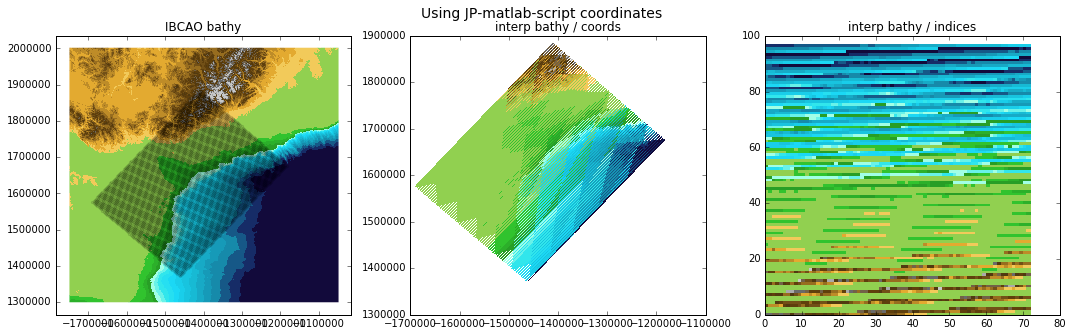

In [9]:
fig, ax = plt.subplots(1,3,figsize=(18,5))
cmap, norm = colormap_ibcao.Colormap()
levels = [-3000, -2000, -1000, 0, 1000, 2000]
ax[0].pcolorfast(x_region, y_region, z_region, vmin = levels[0], vmax = levels[-1], cmap = cmap)
ax[0].scatter(lon_s_coord, lat_s_coord, c='k', s=5, alpha=0.1)
ax[0].set_title('IBCAO bathy')
ax[1].pcolor(lon_s_coord, lat_s_coord, z_canyon, vmin = levels[0], vmax = levels[-1], cmap = cmap)
ax[1].set_title('interp bathy / coords')
ax[2].pcolor(z_canyon, vmin = levels[0], vmax = levels[-1], cmap = cmap)
ax[2].set_title('interp bathy / indices')
fig.suptitle('Using JP-matlab-script coordinates', fontsize=14)

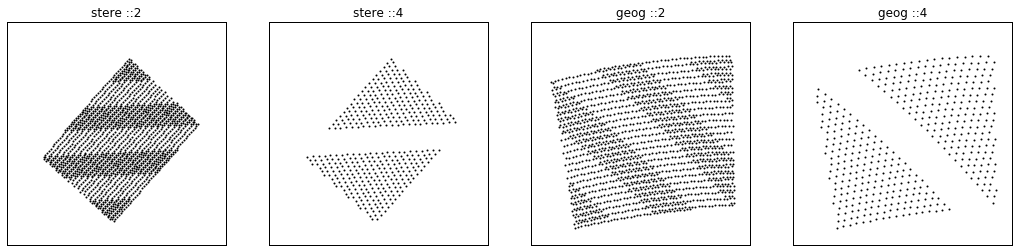

In [10]:
fig, ax = plt.subplots(1,4,figsize=(18,4))
lon_these = [lon_s_coord, lon_s_coord, lon_g_coord, lon_g_coord]
lat_these = [lat_s_coord, lat_s_coord, lat_g_coord, lat_g_coord]
ns = [2, 4, 2, 4]
titles = ['stere', 'stere', 'geog', 'geog']
for lon_this, lat_this, n, i, title in zip (lon_these, lat_these, ns, np.arange(4), titles):
    ax[i].scatter(lon_this[::n,::n], lat_this[::n,::n], s = 1)
    ax[i].set_title(title+' ::'+str(n))
    ax[i].xaxis.set_visible(False); ax[i].yaxis.set_visible(False)

# B) From SEAgrid

In [8]:
X_region, Y_region = np.meshgrid(x_region, y_region) 
points = np.c_[np.ravel(X_region), np.ravel(Y_region)]
values = np.ravel(z_region)
# ----------------------------------

z_canyon = griddata(points, values, (lon_s_grid, lat_s_grid), method='nearest')

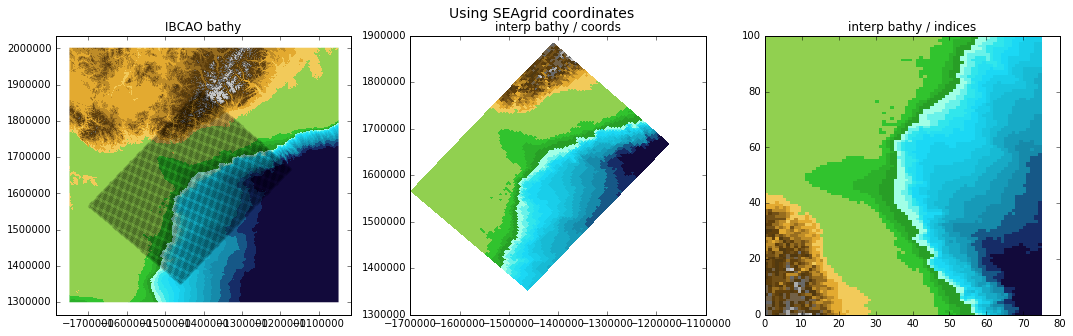

In [9]:
fig, ax = plt.subplots(1,3,figsize=(18,5))
cmap, norm = colormap_ibcao.Colormap()
levels = [-3000, -2000, -1000, 0, 1000, 2000]
ax[0].pcolorfast(x_region, y_region, z_region, vmin = levels[0], vmax = levels[-1], cmap = cmap)
ax[0].scatter(lon_s_grid, lat_s_grid, c='k', s=5, alpha=0.1)
ax[0].set_title('IBCAO bathy')
ax[1].pcolor(lon_s_grid, lat_s_grid, z_canyon, vmin = levels[0], vmax = levels[-1], cmap = cmap)
ax[1].set_title('interp bathy / coords')
ax[2].pcolor(z_canyon, vmin = levels[0], vmax = levels[-1], cmap = cmap)
ax[2].set_title('interp bathy / indices')
fig.suptitle('Using SEAgrid coordinates', fontsize=14)

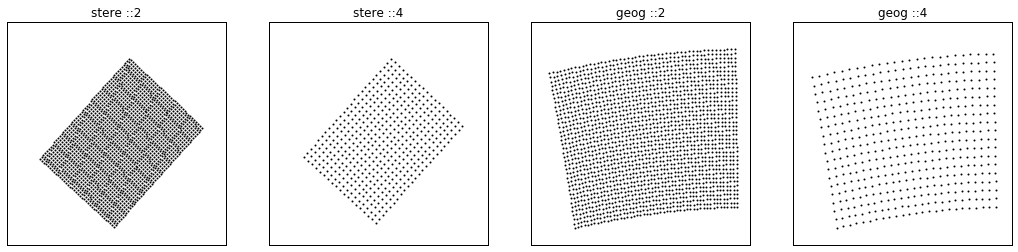

In [11]:
fig, ax = plt.subplots(1,4,figsize=(18,4))
lon_these = [lon_s_grid, lon_s_grid, lon_g_grid, lon_g_grid]
lat_these = [lat_s_grid, lat_s_grid, lat_g_grid, lat_g_grid]
ns = [2, 4, 2, 4]
titles = ['stere', 'stere', 'geog', 'geog']
for lon_this, lat_this, n, i, title in zip (lon_these, lat_these, ns, np.arange(4), titles):
    ax[i].scatter(lon_this[::n,::n], lat_this[::n,::n], s = 1)
    ax[i].set_title(title+' ::'+str(n))
    ax[i].xaxis.set_visible(False); ax[i].yaxis.set_visible(False)

# C) Rotate and Cubic

In [8]:
lon_s_grid_rotate = np.fliplr(np.rot90(lon_s_grid, 3))
lat_s_grid_rotate = np.fliplr(np.rot90(lat_s_grid, 3))
# ----------------------------------

X_region, Y_region = np.meshgrid(x_region, y_region) 
points = np.c_[np.ravel(X_region), np.ravel(Y_region)]
values = np.ravel(z_region)
# ----------------------------------

z_canyon = griddata(points, values, (lon_s_grid_rotate, lat_s_grid_rotate), method='cubic')

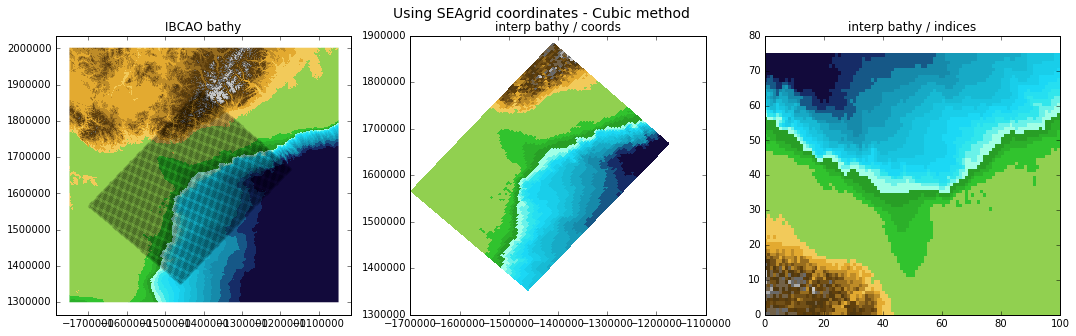

In [9]:
fig, ax = plt.subplots(1,3,figsize=(18,5))
levels = [-3000, -2000, -1000, 0, 1000, 2000]
cmap, norm = colormap_ibcao.Colormap()
ax[0].pcolorfast(x_region, y_region, z_region, vmin = levels[0], vmax = levels[-1], cmap = cmap)
ax[0].scatter(lon_s_grid_rotate, lat_s_grid_rotate, c='k', s=5, alpha=0.1)
ax[0].set_title('IBCAO bathy')
ax[1].pcolormesh(lon_s_grid_rotate, lat_s_grid_rotate, z_canyon, vmin = levels[0], vmax = levels[-1], cmap = cmap)
ax[1].set_title('interp bathy / coords')
ax[2].pcolormesh(z_canyon, vmin = levels[0], vmax = levels[-1], cmap = cmap)
ax[2].set_title('interp bathy / indices')
fig.suptitle('Using SEAgrid coordinates - Cubic method', fontsize=14)

# 4) Periodic Boundaries

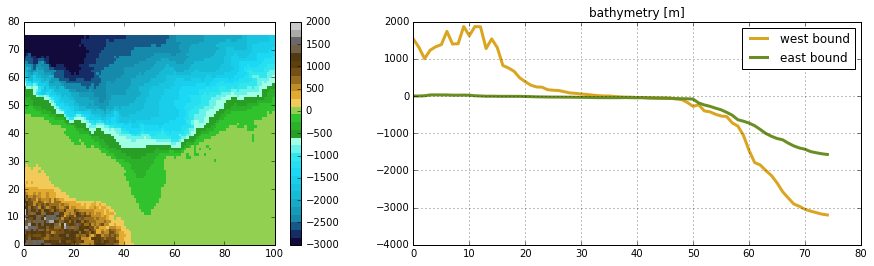

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios':[1.4,2]}, figsize=(15,4))
c = axes[0].pcolormesh(z_canyon, vmin = levels[0], vmax = levels[-1], cmap = cmap)
fig.colorbar(c, ax = axes[0])
axes[1].plot(z_canyon[:, 0], lw = 3, c = 'Goldenrod', label = 'west bound')
axes[1].plot(z_canyon[:, -1], lw = 3, c = 'OliveDrab', label = 'east bound')
axes[1].grid(); axes[1].set_title('bathymetry [m]'); axes[1].legend()

In [11]:
extension = 20
x_extended = np.arange(z_canyon.shape[1] + extension)
x_original = np.append(np.arange(z_canyon.shape[1]),x_extended[-1])
y_original = np.arange(z_canyon.shape[0])
z_original = np.concatenate([z_canyon,z_canyon[:,:1]], axis=1)
# ----------------------------------

X_original, Y_original = np.meshgrid(x_original, y_original)
points = np.c_[np.ravel(X_original), np.ravel(Y_original)]
values = np.ravel(z_original)
# ----------------------------------

X_extended, Y_extended = np.meshgrid(x_extended, y_original)
# ----------------------------------

z_extended_cubic = griddata(points, values, (X_extended, Y_extended), method='cubic')
z_extended_linear = griddata(points, values, (X_extended, Y_extended), method='linear')

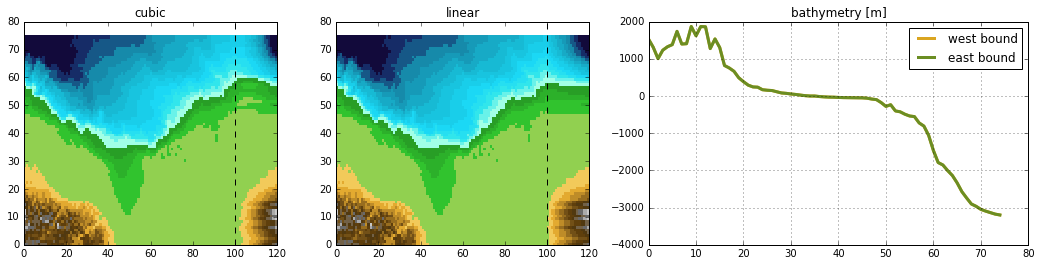

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, gridspec_kw={'width_ratios':[1,1,1.5]}, figsize=(18,4))
axes[0].pcolormesh(z_extended_cubic, vmin = levels[0], vmax = levels[-1], cmap = cmap); axes[0].set_title('cubic')
axes[1].pcolormesh(z_extended_linear, vmin = levels[0], vmax = levels[-1], cmap = cmap); axes[1].set_title('linear')
axes[0].axvline(z_canyon.shape[1], c='k', linestyle='--')
axes[1].axvline(z_canyon.shape[1], c='k', linestyle='--')
axes[2].plot(z_extended_cubic[:, 0], lw = 3, c = 'Goldenrod', label = 'west bound')
axes[2].plot(z_extended_cubic[:, -1], lw = 3, c = 'OliveDrab', label = 'east bound')
axes[2].grid(); axes[2].set_title('bathymetry [m]'); axes[2].legend()

# 5. Level off full depth and land

In [13]:
# from make_mackenzie
fluid_depth = 1300.0

z_1300 = np.array(z_extended_linear, copy=True)
z_1300[z_1300 < -fluid_depth] = -fluid_depth

z_0 = np.array(z_1300, copy=True)
z_0[z_0 > 0] = 0

(array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))


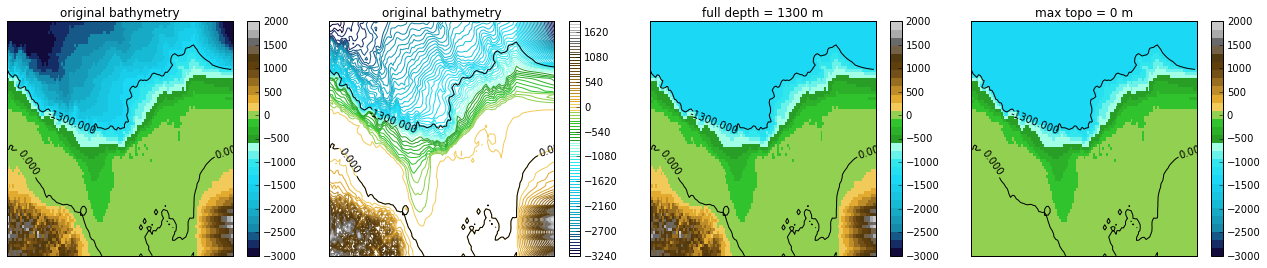

In [14]:
fig, axes = plt.subplots(1,4,figsize=(18,3.8)); plt.tight_layout()
c0 = axes[0].pcolormesh(z_extended_linear, vmin = levels[0], vmax = levels[-1], cmap = cmap)
axes[0].set_title('original bathymetry')
c1 = axes[1].contour(z_extended_linear, 100, level=levels, cmap = cmap)
axes[1].set_title('original bathymetry')
c2 = axes[2].pcolormesh(z_1300, vmin = levels[0], vmax = levels[-1], cmap = cmap)
axes[2].set_title('full depth = 1300 m')
c3 = axes[3].pcolormesh(z_0, vmin = levels[0], vmax = levels[-1], cmap = cmap)
axes[3].set_title('max topo = 0 m')

for c, i in zip([c0, c1, c2, c3], np.arange(4)):
    cs = axes[i].contour(z_extended_linear, levels = [-1300, 0], colors='k',linestyles='-')
    axes[i].clabel(cs, inline=1); fig.colorbar(c, ax = axes[i])
    axes[i].xaxis.set_visible(False); axes[i].yaxis.set_visible(False)

print(np.where(z_1300 < -1300), np.where(z_0 > 0))

# 6. Make positive for NEMO

In [15]:
def make_bathy_positive(z_0):
    z_positive0 = z_0 * -1
    z_positive = np.array(z_positive0, copy=True)
    z_positive[z_positive == -0.] = 0.
    return z_positive

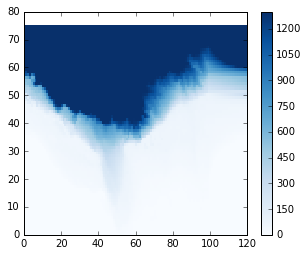

In [16]:
z_positive = make_bathy_positive(z_0)
fig, ax = plt.subplots(1,1,figsize=(5,4))
c = ax.pcolormesh(z_positive, cmap = cm.Blues)
fig.colorbar(c, ax = ax)

# 7. Masking Bathymetry

In [17]:
# Unmasked 
diffs_lat, lat_ij, diffs_lon, lon_ij = bathy_tools.choose_steepest_cells(z_positive)
print(lat_ij, diffs_lat[lat_ij], lon_ij, diffs_lon[lon_ij])

# Masked
z_masked = np.ma.array(z_positive)
diffs_lat, lat_ij, diffs_lon, lon_ij = bathy_tools.choose_steepest_cells(z_masked)
print(lat_ij, diffs_lat[lat_ij], lon_ij, diffs_lon[lon_ij])

(0, 0) nan (0, 0) nan
(0, 50) 2.0 (0, 50) 2.0


# 8. Smoothing Steepness

In [18]:
smooth_factor = 0.2
max_norm_depth_diff = 0.70834736504
z_smoothed = bathy_tools.smooth(z_masked, max_norm_depth_diff, smooth_factor)

In [19]:
z_positive = make_bathy_positive(z_0)
z_masked = np.ma.array(z_positive)
difference = np.subtract(z_smoothed, z_masked)

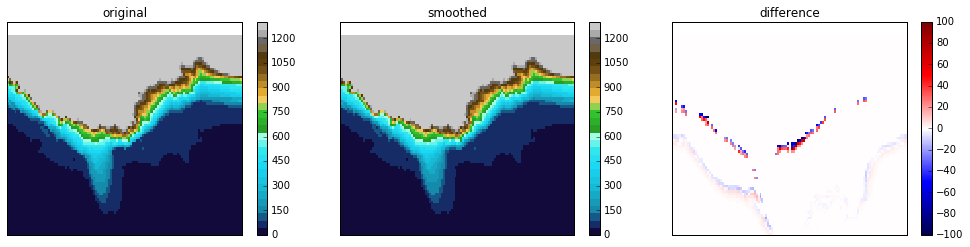

In [20]:
fig, axes = plt.subplots(1,3,figsize=(14,3.5)); plt.tight_layout()
c0 = axes[0].pcolormesh(z_masked, cmap = cmap); axes[0].set_title('original')
c1 = axes[1].pcolormesh(z_smoothed, cmap = cmap); axes[1].set_title('smoothed')
c2 = axes[2].pcolormesh(difference, cmap = cm.seismic, vmin=-100, vmax=100); axes[2].set_title('difference')
for c, i in zip([c0, c1, c2], np.arange(3)):
    axes[i].clabel(cs, inline=1); fig.colorbar(c, ax = axes[i])
    axes[i].xaxis.set_visible(False); axes[i].yaxis.set_visible(False)